In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.nn import functional as F
from importlib import reload
import loupe.line_sampler
from loupe.line_sampler import *
import utils
from utils import kplot

In [2]:
reload(loupe.line_sampler)
from loupe.line_sampler import *

In [3]:
shape = [320,320]
slope = 5
sparsity = .25
preselect = True
preselect_num = 24
sampler = LOUPESampler(shape, slope, sparsity, preselect, preselect_num)

In [ ]:
a = list(sampler.parameters())

In [4]:
data     = np.load('/home/huangz78/data/traindata_x.npz')
dtyp     = torch.float
xfull    = torch.tensor(data['xfull'],dtype=dtyp)
fullmask = torch.tensor(data['mask'])

In [5]:
y = torch.fft.fftn(xfull[0:3,:,:],dim=(0,1),norm='ortho')
print(y.shape)

torch.Size([3, 320, 320])


> /home/huangz78/mri/loupe/line_sampler.py(176)forward()
    174             rescaled_mask  = self.rescale(prob_mask, sparsity)
    175         breakpoint()
--> 176         binarized_mask = self.binarize(rescaled_mask)
    177 
    178         binarized_mask[..., :self.preselect_num_one_side , :] = 1  # wrt unrolled masks

ipdb> n
> /home/huangz78/mri/loupe/line_sampler.py(178)forward()
    176         binarized_mask = self.binarize(rescaled_mask)
    177 
--> 178         binarized_mask[..., :self.preselect_num_one_side , :] = 1  # wrt unrolled masks
    179         binarized_mask[..., -self.preselect_num_one_side:, :] = 1
    180 

ipdb> n
> /home/huangz78/mri/loupe/line_sampler.py(179)forward()
    177 
    178         binarized_mask[..., :self.preselect_num_one_side , :] = 1  # wrt unrolled masks
--> 179         binarized_mask[..., -self.preselect_num_one_side:, :] = 1
    180 
    181 #         neg_entropy = self._mask_neg_entropy(rescaled_mask)

ipdb> n
> /home/huangz78/mri/loupe/

/home/huangz78/mri/utils.py:98: RuntimeWarning: divide by zero encountered in log
  hd1 = axs.imshow(np.log(y),cmap=cmap)
/home/huangz78/mri/utils.py:100: RuntimeWarning: divide by zero encountered in log
  hd1 = axs.imshow(np.log(np.abs(y)),cmap=cmap)


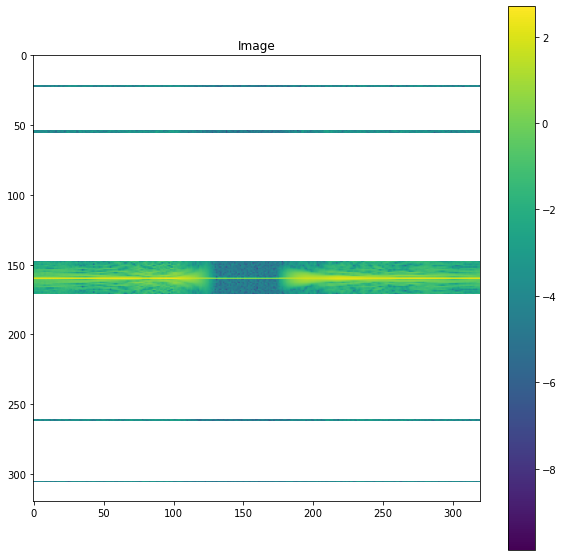

ipdb> kplot(masked_kspace[0,1,:,:].detach().numpy(),log=True,roll=True)


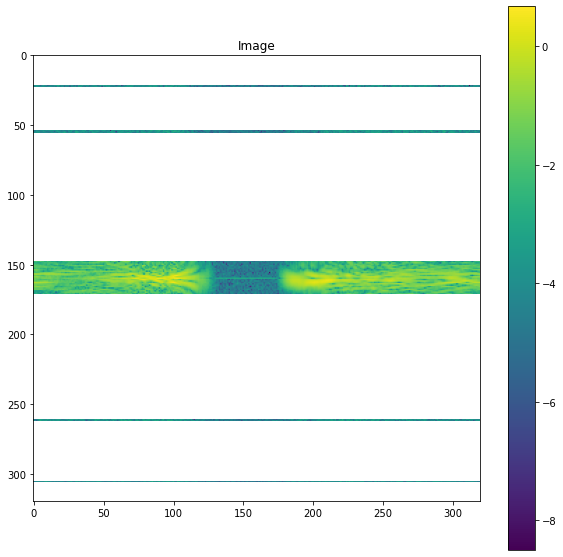

ipdb> q


BdbQuit: 

In [6]:
sampler(y,sparsity)

In [ ]:
a = torch.randn(5,4)
(a>0).float()